In [1]:
from matplotlib import pyplot as plt
import numpy as np

from data.MNIST.mnist_csv_loader import load_data

batch_size = 64

In [2]:
%%time
train_x_raw, train_y_raw = load_data('../data/MNIST/csv/mnist_train.csv')
test_x_raw, test_y_raw = load_data('../data/MNIST/csv/mnist_test.csv')

CPU times: user 26.4 s, sys: 391 ms, total: 26.8 s
Wall time: 26.8 s


In [3]:
train_x_raw = train_x_raw[np.where((train_y_raw == 4) | (train_y_raw == 9))[0]]
train_y_raw = train_y_raw[np.where((train_y_raw == 4) | (train_y_raw == 9))[0]]
test_x_raw = test_x_raw[np.where((test_y_raw == 4) | (test_y_raw == 9))[0]]
test_y_raw = test_y_raw[np.where((test_y_raw == 4) | (test_y_raw == 9))[0]]

In [4]:
def normalize(x: np.ndarray) -> np.ndarray:
    min_v, max_v = np.min(x), np.max(x)
    return ((x + min_v) / (max_v - min_v)) * 2. - 1.

In [5]:
# prepare training data
n = train_x_raw.shape[0]
train_x = [
    normalize(train_x_raw[i:i+batch_size])
    for i in range(0, n, batch_size)
][:-1]
train_y = [
    train_y_raw[i:i+batch_size]
    for i in range(0, n, batch_size)
][:-1]
train_y_1hot = []
for y in train_y:
    y1 = np.zeros((batch_size, 2))
    y1[y.reshape((batch_size)) == 4,0] = 1.
    y1[y.reshape((batch_size)) == 9,1] = 1.
    train_y_1hot.append(y1)

In [6]:
# preprocess test set to get accuracy
test_x = normalize(test_x_raw)
test_y = test_y_raw
n = len(test_y)
test_y_1hot = np.zeros((n, 2))
test_y_1hot[test_y.reshape((n)) == 4,0] = 1
test_y_1hot[test_y.reshape((n)) == 9,1] = 1

def get_accuracy(model):
    result = model.inference(test_x)
    return (np.argmax(result, axis=1) == np.argmax(test_y_1hot, axis=1)).astype('float').sum() / float(n)

In [7]:
from src.model import Model

In [8]:
# build model
m = Model(learning_rate=.003).layer(28*28).layer(20).layer(20).layer(2)

In [9]:
# repeating data set (because I don't have enough)
xx = train_x*6
yy = train_y_1hot*6

# collect cost and accuracy for plotting
cost, accuracy = [], []

In [10]:
%%time
# train
for i in range(len(xx)):
    x, y = xx[i], yy[i]
    m.inference(x)
    cost.append(m.get_cost(y))
    m.back_prop(y)
    accuracy.append(get_accuracy(m))

CPU times: user 18.7 s, sys: 4.31 s, total: 23 s
Wall time: 11.6 s


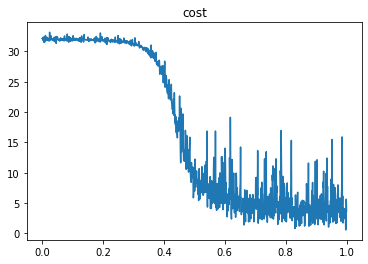

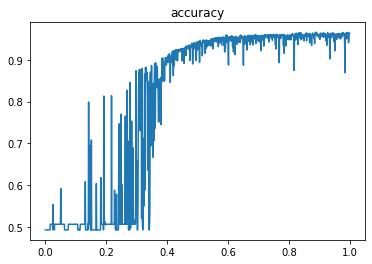

0.963837267704671


In [11]:
# plot cost and accuracy
fig, ax = plt.subplots()
ax.plot(np.linspace(0,1,len(cost)), np.array(cost))
ax.set_title('cost')
plt.show()
fig, ax = plt.subplots()
ax.plot(np.linspace(0,1,len(accuracy)), np.array(accuracy))
ax.set_title('accuracy')
plt.show()
print(accuracy[-1])

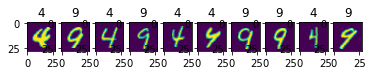

In [12]:
# randomly pick some test data points to give some intuitive proof
n = 10
random_pick = test_x[np.random.choice(np.arange(test_x.shape[0]), n)]
result = m.inference(random_pick)
fig, axs = plt.subplots(1, n)
for i in range(n):
    # use prediction as title
    axs[i].set_title('{}'.format(4 if result[i][0] > result[i][1] else 9))
    axs[i].imshow(random_pick[i].reshape((28, 28)))
plt.show()